# Import necessary modules

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Processing
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import random

# gensim
import gensim
from gensim.models import Word2Vec

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Neural networks
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, Flatten, Dropout
from keras.initializers import Constant
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils import plot_model

Using TensorFlow backend.


# Prepare Data

In [2]:
df = pd.read_csv("clean_compiled_transcripts.csv", index_col = "Participant_ID")
df.head()

,Transcript,PHQ_Score,PHQ_Binary
Participant_ID,,,
300,good atlanta georgia um my parents um i love i...,2,0
301,thank you mmm k i good thank you i los angeles...,3,0
302,i fine yourself i los angeles california part ...,4,0
303,okay bout yourself california yeah oh well it ...,0,0
304,i good um los angeles california um cool weath...,6,0


## Convert transcripts to padded sequences (skip if you have the numpy data)

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.Transcript)
vocab_size = len(tokenizer.word_index) + 1

word_index = tokenizer.word_index
word_index

{'i': 1,
 'um': 2,
 'it': 3,
 'uh': 4,
 'you': 5,
 'my': 6,
 'know': 7,
 'like': 8,
 'me': 9,
 'really': 10,
 'would': 11,
 'yeah': 12,
 'think': 13,
 'they': 14,
 'people': 15,
 'well': 16,
 'good': 17,
 'we': 18,
 'things': 19,
 'get': 20,
 'lot': 21,
 'time': 22,
 'go': 23,
 'she': 24,
 'he': 25,
 'pretty': 26,
 'going': 27,
 'one': 28,
 'probably': 29,
 'them': 30,
 'little': 31,
 'life': 32,
 'something': 33,
 'say': 34,
 'could': 35,
 'mm': 36,
 'feel': 37,
 'guess': 38,
 'much': 39,
 'years': 40,
 'mean': 41,
 'different': 42,
 'yes': 43,
 'kinda': 44,
 'myself': 45,
 'back': 46,
 'want': 47,
 'oh': 48,
 'see': 49,
 'right': 50,
 'got': 51,
 'sometimes': 52,
 'her': 53,
 'always': 54,
 'went': 55,
 'hard': 56,
 'ago': 57,
 'work': 58,
 'okay': 59,
 'kind': 60,
 'school': 61,
 'try': 62,
 'family': 63,
 'maybe': 64,
 'love': 65,
 'actually': 66,
 'make': 67,
 'day': 68,
 'friends': 69,
 'happy': 70,
 'way': 71,
 'thing': 72,
 'anything': 73,
 'last': 74,
 'job': 75,
 'two': 76,
 

In [4]:
maxlen = 1000

def prepare(X):
    X_seq = tokenizer.texts_to_sequences(X)
    X_mat = sequence.pad_sequences(X_seq, maxlen=maxlen, padding='post')
    
    return X_mat

## Split the dataset (skip if you have the numpy data)

In [5]:
X = prepare(df.Transcript)
y = df.PHQ_Binary

In [6]:
def train_test(X, y, testfile='test_split_Depression_AVEC2017.csv'):
    test_participants = pd.read_csv(testfile)['participant_ID'].values
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for i in range(y.shape[0]):
        participant_no = y.index[i]
        
        if participant_no in test_participants:
            X_test.append(X[i])
            y_test.append(y[participant_no])
        else:
            X_train.append(X[i])
            y_train.append(y[participant_no])
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

X_train, X_test, y_train, y_test = train_test(X, y)

In [7]:
RANDOM_STATE = 42

# because the RandomUnderSampler does not work here
def undersampling(X_train, y_train):
    random.seed(RANDOM_STATE)
    
    neg_list = [i for i in range(len(y_train)) if y_train[i] == 0]
    pos_list = [i for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_list) < len(pos_list):
        minority_list = neg_list
        majority_list = pos_list
    else:
        minority_list = pos_list
        majority_list = neg_list
        
    sampled_list = random.sample(majority_list, len(minority_list))
    
    final_list = sampled_list + minority_list
    
    X_train_us = []
    y_train_us = []
    
    for i in final_list:
        X_train_us.append(X_train[i])
        y_train_us.append(y_train[i])
                                 
    return np.array(X_train_us), np.array(y_train_us)

X_train, y_train = undersampling(X_train, y_train)

In [8]:
# shuffle the train data in unison because data is in order
# reduces poor performance during k-cross validation when sampling data

X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82, 1000), (45, 1000), (82,), (45,))

In [9]:
np.save("X_train_lstm.npy", X_train)
np.save("X_test_lstm.npy", X_test)
np.save("y_train_lstm.npy", y_train)
np.save("y_test_lstm.npy", y_test)

## Load dataset 

In [10]:
X_train = np.load("X_train_lstm.npy")
X_test = np.load("X_test_lstm.npy")
y_train = np.load("y_train_lstm.npy")
y_test = np.load("y_test_lstm.npy")

# More preprocessing

## Evaluation metrics

In [11]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## Run model

In [12]:
class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return

metrics = Metrics()

In [13]:
def train_NN(model, model_name):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint_filepath = f'{model_name}.h5'

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.2, callbacks=[checkpoint, metrics])
    loss, acc = model.evaluate(X_test, y_test)

    model = load_model(checkpoint_filepath)

    print('Test loss:', loss)
    print('Test accuracy:', acc)
    
    return model

# LSTM

## Corpus trained Word Embeddings

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, dropout=0.2, recurrent_dropout=0.2)`
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 128)         1009152   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,045,003
Trainable params: 1,045,003
Non-trainable params: 0
_________________________________________________________________
None


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 65 samples, validate on 17 samples
Epoch 1/30
65/65 [==============================] - 5s 79ms/step - loss: 0.6895 - accuracy: 0.4923 - val_loss: 0.6931 - val_accuracy: 0.4706
 — val_f1: 0.4 — val_precision: 0.5 — val_recall: 0.3333333333333333
Epoch 2/30
65/65 [==============================] - 4s 62ms/step - loss: 0.6992 - accuracy: 0.4769 - val_loss: 0.6921 - val_accuracy: 0.7059
 — val_f1: 0.6153846153846153 — val_precision: 1.0 — val_recall: 0.4444444444444444
Epoch 3/30
65/65 [==============================] - 4s 61ms/step - loss: 0.6993 - accuracy: 0.4769 - val_loss: 0.6909 - val_accuracy: 0.5882
 — val_f1: 0.5333333333333333 — val_precision: 0.6666666666666666 — val_recall: 0.4444444444444444
Epoch 4/30
65/65 [==============================] - 4s 61ms/step - loss: 0.6903 - accuracy: 0.5385 - val_loss: 0.6901 - val_accuracy: 0.5882
 — val_f1: 0.5333333333333333 — val_precision: 0.6666666666666666 — val_recall: 0.4444444444444444
Epoch 5/30
65/65 [=======================

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


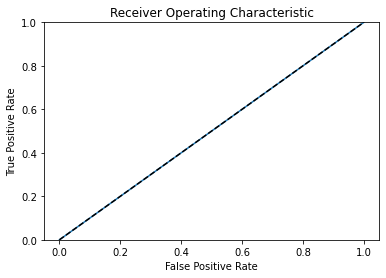

In [14]:
model_name = "corpus_lstm"

corpus_lstm_model = Sequential()

corpus_lstm_model.add(Embedding(vocab_size, 128, input_length=maxlen, dropout=0.2))
corpus_lstm_model.add(LSTM(50, dropout_U = 0.2, dropout_W = 0.2))
corpus_lstm_model.add(Dropout(0.5))
corpus_lstm_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(corpus_lstm_model.summary())
#plot_model(corpus_lstm_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(corpus_lstm_model, model_name)

print('=' * 50)

predictions = corpus_lstm_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()
evaluate_on_training_set(y_test, y_pred)

## Word2Vec

In [15]:
if not Path('./GoogleNews-vectors-negative300.bin.gz').exists():
    !wget -P ./ "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [16]:
%%time

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)
print('word2vec model loaded')

word2vec model loaded
CPU times: user 48.3 s, sys: 4.28 s, total: 52.6 s
Wall time: 52.8 s


In [17]:
wv_embedding_dim = 300

wv_embedding_matrix = np.zeros((len(word_index) + 1, wv_embedding_dim))
for word, i in word_index.items():
    if word in wv: 
        embedding_vector = wv[word]
        wv_embedding_matrix[i] = embedding_vector
        
wv_embedding_layer = Embedding(len(word_index) + 1, wv_embedding_dim, weights=[wv_embedding_matrix], 
                               input_length=maxlen, trainable=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 300)         2365200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,407,857
Trainable params: 42,657
Non-trainable params: 2,365,200
_________________________________________________________________
None
Train on 65 samples, validate on 17 samples
Epoch 1/30
65/65 [==============================] - 4s 59ms/step - loss: 0.6904 - accuracy: 0.5385 - val_loss: 0.6939 - val_accuracy: 0.3529
 — val_f1: 0.4761904761904762 — val_precision: 

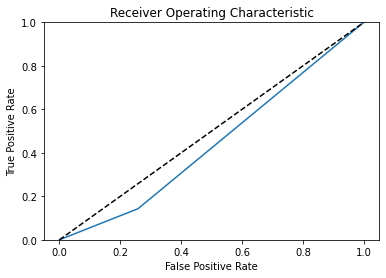

In [18]:
model_name = "word2vec_lstm"

word2vec_lstm_model = Sequential()
word2vec_lstm_model.add(wv_embedding_layer)
word2vec_lstm_model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.25))
word2vec_lstm_model.add(Dropout(0.5))
word2vec_lstm_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(word2vec_lstm_model.summary())
#plot_model(word2vec_lstm_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(word2vec_lstm_model, model_name)

print('=' * 50)

predictions = word2vec_lstm_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()
evaluate_on_training_set(y_test, y_pred)

# GloVe

In [19]:
if not Path('./glove.twitter.27B.zip').exists():
    !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
    !unzip glove*.zip

In [20]:
glove_embedding_index = {}
glove_embedding_dim = 100

f = open('glove.twitter.27B.100d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    glove_embedding_index[word] = coeff

f.close()

In [21]:
glove_embedding_matrix = np.zeros((len(word_index) + 1, glove_embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_embedding_index.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector

glove_embedding_layer = Embedding(len(word_index) + 1, glove_embedding_dim, weights=[glove_embedding_matrix], 
                                  input_length=maxlen, trainable=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         788400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 805,457
Trainable params: 17,057
Non-trainable params: 788,400
_________________________________________________________________
None
Train on 65 samples, validate on 17 samples
Epoch 1/30
65/65 [==============================] - 4s 61ms/step - loss: 0.6507 - accuracy: 0.5385 - val_loss: 0.6852 - val_accuracy: 0.5294
 — val_f1: 0.6363636363636364 — val_precision: 0.53

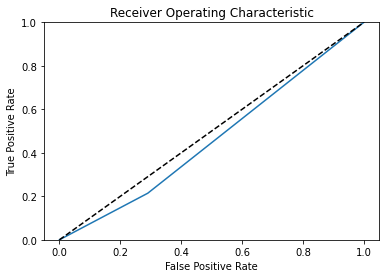

In [22]:
model_name = "glove_lstm"

glove_lstm_model = Sequential()
glove_lstm_model.add(glove_embedding_layer)
glove_lstm_model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.25))
glove_lstm_model.add(Dropout(0.5))
glove_lstm_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(glove_lstm_model.summary())
#plot_model(glove_lstm_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(glove_lstm_model, model_name)

print('=' * 50)

predictions = glove_lstm_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()
evaluate_on_training_set(y_test, y_pred)